In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [3]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabates_dataset = load_diabetes()
print(diabates_dataset["DESCR"])

# First 10 columns are numeric predictive values

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [5]:
# Save the input and target variables

print(diabates_dataset.keys())

data = diabates_dataset["data"]
targets = diabates_dataset['target']

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


In [8]:
# Normalise the target data (this will make clearer training curves)
print(targets)

targets = (targets - targets.mean(axis=0)) / targets.std()

[-1.47194752e-02 -1.00165882e+00 -1.44579915e-01  6.99512942e-01
 -2.22496178e-01 -7.15965848e-01 -1.83538046e-01 -1.15749134e+00
 -5.47147277e-01  2.05006151e+00 -6.64021672e-01 -1.07957508e+00
  3.48889755e-01  4.26806019e-01 -4.43258925e-01  2.45001404e-01
  1.80071184e-01 -1.05621783e-01 -7.15965848e-01  2.06043272e-01
 -1.09256112e+00 -1.33929596e+00 -1.09256112e+00  1.20596866e+00
  4.13819975e-01  6.47568766e-01 -1.96524090e-01 -8.71798376e-01
 -2.74440354e-01  1.69943833e+00 -3.00412442e-01 -1.20943552e+00
  2.45262887e+00 -8.45826288e-01 -1.13151925e+00 -6.51035629e-01
  1.46568953e+00  1.60853602e+00  1.29687096e+00 -8.06868156e-01
 -6.77007716e-01 -1.26137969e+00 -1.18346343e+00 -7.80896068e-01
  1.38777327e+00 -1.28735178e+00  4.91736239e-01 -1.31593871e-01
 -1.00165882e+00 -1.31593871e-01  3.72247006e-02  9.46247777e-01
 -1.20943552e+00 -6.25063541e-01  3.87847887e-01 -3.13398486e-01
 -1.30033783e+00 -1.49512849e+00  2.32015360e-01  2.32015360e-01
 -1.18346343e+00 -1.05621

In [14]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size = 0.1)

print(train_data.shape)
print(test_data.shape)
print(train_tragets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [33]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
            Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(1)
    ])
    return model

model = get_model()

In [32]:
# Print the model summary

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               1408      
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 dense_27 (Dense)            (None, 1)                

In [34]:
# Compile the model

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [35]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [36]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.7307 - mae: 0.6534 - 29ms/epoch - 14ms/step


[0.7307016253471375, 0.6533843874931335]

#### Plot the learning curves

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

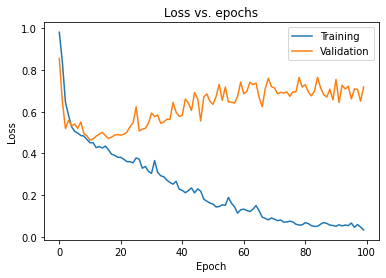

In [38]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [39]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [40]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [41]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-5, 0.3)

In [42]:
# Compile the model

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [43]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [44]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.5026 - mae: 0.5655 - 17ms/epoch - 9ms/step


[0.5025736093521118, 0.5655041933059692]

#### Plot the learning curves

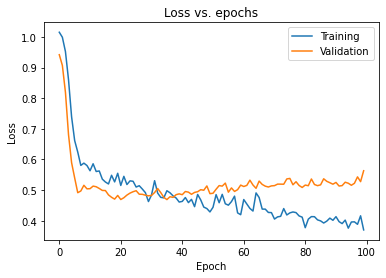

In [45]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Batch normalisation layers

### Batch normalisation - Defining the model

We can implement batch normalisation into our model by adding it in the same way as any other layer.

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [47]:
# Build the model

BN_model = Sequential([
        Dense(64, input_shape=[train_data.shape[1],], activation="relu"),
        BatchNormalization(),  # <- Batch normalisation layer
        Dropout(0.5),
        BatchNormalization(),  # <- Batch normalisation layer
        Dropout(0.5),
        Dense(256, activation='relu'),
])

# NB: We have not added the output layer because we still have more layers to add!

In [48]:
BN_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 64)                704       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 256)              

Recall that there are some parameters and hyperparameters associated with batch normalisation.

* The hyperparameter **momentum** is the weighting given to the previous running mean when re-computing it with an extra minibatch. By **default**, it is set to 0.99.

* The hyperparameter **$\epsilon$** is used for numeric stability when performing the normalisation over the minibatch. By **default** it is set to 0.001.

* The parameters **$\beta$** and **$\gamma$** are used to implement an affine transformation after normalisation. By **default**, $\beta$ is an all-zeros vector, and $\gamma$ is an all-ones vector.

### Customising parameters
These can all be changed (along with various other properties) by adding optional arguments to `tf.keras.layers.BatchNormalization()`.

We can also specify the axis for batch normalisation. By default, it is set as -1.

Let's see an example.

In [49]:
BN_model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, 
    epsilon=0.005,
    axis = -1,
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
    gamma_initializer=tf.keras.initializers.Constant(value=0.9)
))

In [50]:
BN_model.add(Dense(1))

In [52]:
BN_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 64)                704       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 256)              

In [51]:
BN_model.compile(optimizer='adam',
                loss='mse',
                metrics=['mae'])

In [55]:
BN_history = BN_model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64,verbose=False)

In [56]:
BN_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.4779 - mae: 0.6022 - 54ms/epoch - 27ms/step


[0.47791680693626404, 0.6022014617919922]

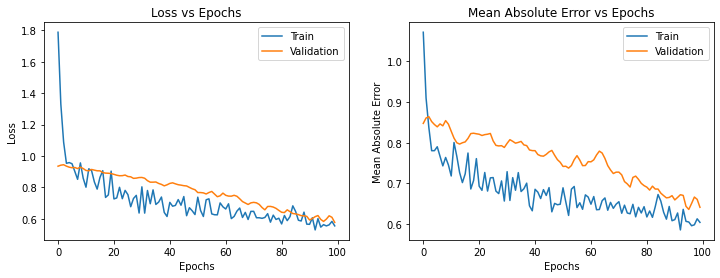

In [57]:
# Plot the learning curves

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

frame = pd.DataFrame(BN_history.history)
epochs = np.arange(len(frame))

fig = plt.figure(figsize=(12,4))

# Loss plot
ax = fig.add_subplot(121)
ax.plot(epochs, frame['loss'], label="Train")
ax.plot(epochs, frame['val_loss'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epochs")
ax.legend()

# Accuracy plot
ax = fig.add_subplot(122)
ax.plot(epochs, frame['mae'], label="Train")
ax.plot(epochs, frame['val_mae'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Mean Absolute Error vs Epochs")
ax.legend()

## Further reading and resources 
* https://keras.io/layers/normalization/
* https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/BatchNormalization

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [ ]:
# Write a custom callback



In [ ]:
# Re-build the model



In [ ]:
# Compile the model



#### Train the model with the callback

In [ ]:
# Train the model, with some of the data reserved for validation



In [ ]:
# Evaluate the model



In [ ]:
# Make predictions with the model



***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [ ]:
# Re-train the unregularised model



In [ ]:
# Evaluate the model on the test set



In [ ]:
# Re-train the regularised model



In [ ]:
# Evaluate the model on the test set



#### Plot the learning curves

In [ ]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()